# Notes for user:

*   This notebook will use the dataset COVID-19 (positive cases and death rates) and forex to predict the forex spot price of a currency pair.
*   What to ask user before using this application:
*   What currency pair are you interested in? GBP/USD (This layout means that the base currency is USD)
*   The currency the user wants to look at is how much the USD is worth to the GBP.
*   Therefore, we look at the death rates & positive cases in the US.
*   We are looking at dates: 31st Dec 2019 - 31st July 2020.
*   LSTMs are good at looking at changed over time. 


# Part 2A: Univariate CNN

Using Forex price as input into an CNN model to predict Forex Spot Price of that currency pair.

# Imports

In [1]:
# Imports
!pip install git+https://github.com/tensorflow/docs
import pathlib
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
#plotting
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
plt.style.use('seaborn')
from matplotlib import rcParams
# metrics
import math
# to create model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-rc7l7fc0
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-rc7l7fc0
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.06cc84213c3b6a0826b1773f5ee09eec0c1bcad22_-cp36-none-any.whl size=127319 sha256=7271bbe166450c0630750ed7978317b90e225194c39417c782c0762f94f947ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-4wtmi9i5/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs
2.3.0


In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Data Collection


In [3]:
# Import forex
dataset_data= pd.read_csv('GBP_USD.csv', na_values = "?", comment='\t', skipinitialspace=True)
dataset = dataset_data.copy()
dataset = dataset.fillna(method='ffill')
# forex_dataset = forex_dataset_data.dropna()

In [4]:
# Why are these different?
print(dataset.shape)

(214, 6)


# Data Preprocessing / Data Cleaning & Collating
*   Eliminating columns we dont want
*   Merging tables based on 'Date' column
*   Dates in question: Dec 31 2019 - Jul 31, 2020
*   Once complete we pop the 'date' we merged on 

In [5]:
# Filter dataset
date = dataset['Date']
dataset.pop('Date')
dataset.pop('Open')
dataset.pop('High')
dataset.pop('Low')
dataset.pop('Change %')


0      -0.04%
1       0.76%
2       0.49%
3       0.38%
4       0.72%
        ...  
209     0.62%
210    -0.44%
211    -0.82%
212    -0.05%
213     1.11%
Name: Change %, Length: 214, dtype: object

# Plotting Features before Normalisation

## Organising date for plotting

In [6]:
dateFormatting = pd.DataFrame({'new_date': pd.date_range('2019-12-31', '2020-07-31', periods=len(date))})
print(dateFormatting)

      new_date
0   2019-12-31
1   2020-01-01
2   2020-01-02
3   2020-01-03
4   2020-01-04
..         ...
209 2020-07-27
210 2020-07-28
211 2020-07-29
212 2020-07-30
213 2020-07-31

[214 rows x 1 columns]


In [7]:
# Convert date to list so that we can use the dates to plot on graph
my_xticks = dateFormatting['new_date'].tolist()
# print(my_xticks)

## Plotting Forex Spot Price

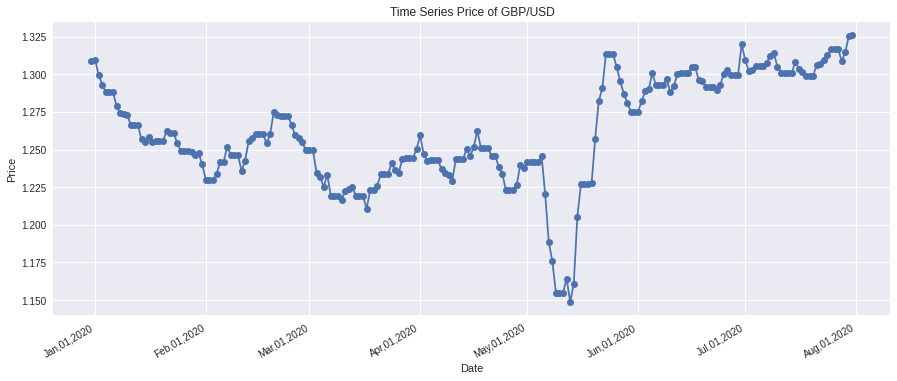

In [8]:
# Plotted prices and dates
# Notice how the dates start and end

rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
price = np.array(dataset['Price'])
plt.plot_date(dates,price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.title('Time Series Price of GBP/USD')
plt.xlabel('Date')
plt.ylabel('Price')
plt.gca().xaxis.set_major_formatter(date_format)

# Plotting Features after Normalisation

In [9]:
price_frame = pd.DataFrame(np.concatenate([price]), columns= ["Price"])
price_frame

,Price
0,1.3090
1,1.3095
2,1.2996
3,1.2932
4,1.2882
...,...
209,1.3169
210,1.3088
211,1.3146
212,1.3255


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
normalisation_price = scaler.fit_transform(price_frame).reshape(-1,1)


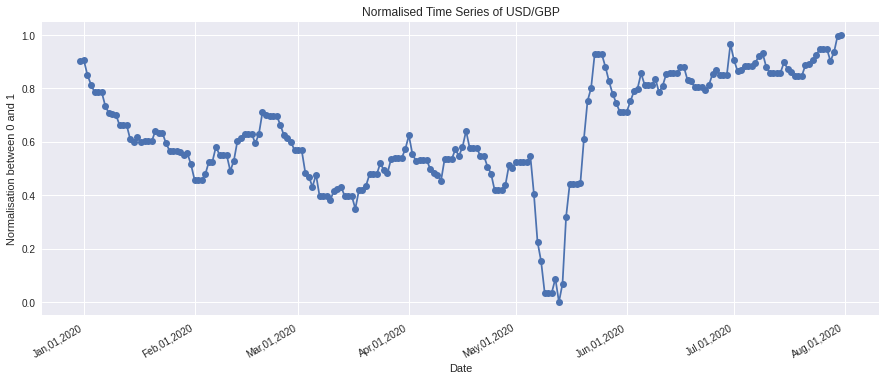

In [11]:
rcParams['figure.figsize'] = 15,6
dates = np.array(dateFormatting['new_date'])
plt.plot_date(dates, normalisation_price, linestyle ='solid')
plt.gcf().autofmt_xdate()
date_format = mpl_dates.DateFormatter('%b,%d,%Y')
plt.gca().xaxis.set_major_formatter(date_format)

plt.title('Normalised Time Series of USD/GBP')
plt.ylabel('Normalisation between 0 and 1')
plt.xlabel('Date')
plt.show()


# Splitting Data into Train, Validation & Test


In [12]:
new_dataset = normalisation_price

In [13]:
# Test, Validation, Train 
# This should be ordered in respect to date – not cross validation or random seed
# We are going to divide our data based on date because the next data is always dependent on the previous data
# 65% of the total length of my datadrame
# 35% validation/test size/ 
training_size = int(len(new_dataset)*0.80)
test_size = (len(new_dataset)-training_size)//2 # // Rounds down
train_data, valset_data, test_data = new_dataset[0:training_size], new_dataset[training_size:(training_size + test_size)],new_dataset[(training_size + test_size):]
print(train_data.shape)
print(valset_data.shape)
print(test_data.shape)

(171, 1)
(21, 1)
(22, 1)


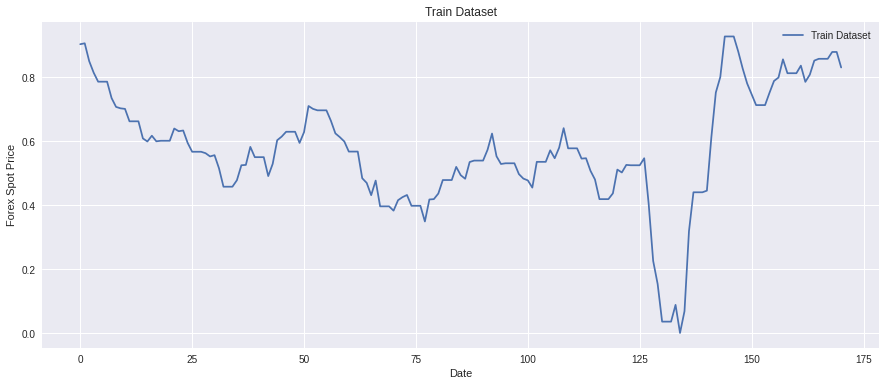

In [14]:
# Start
plt.plot(train_data, label="Train Dataset")
# as you can see th test data and train is divided because we want to test after a specific day
plt.title('Train Dataset')
plt.ylabel('Forex Spot Price')
plt.xlabel('Date')
plt.legend()
plt.show()

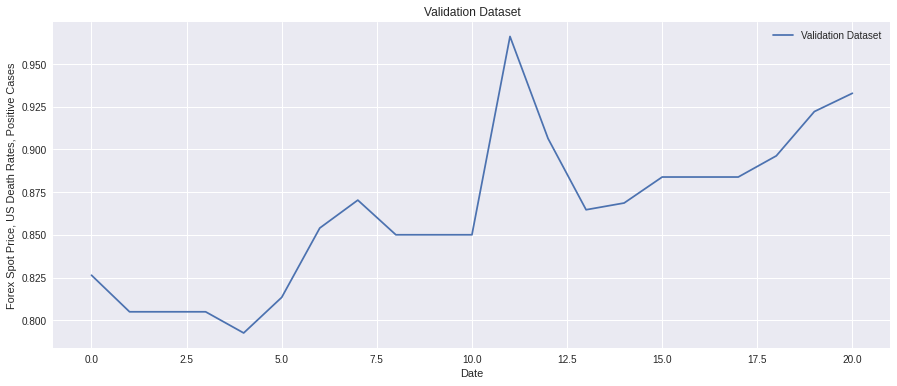

In [15]:
# Middle
plt.plot(valset_data, label="Validation Dataset")
plt.title('Validation Dataset')
plt.ylabel('Forex Spot Price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

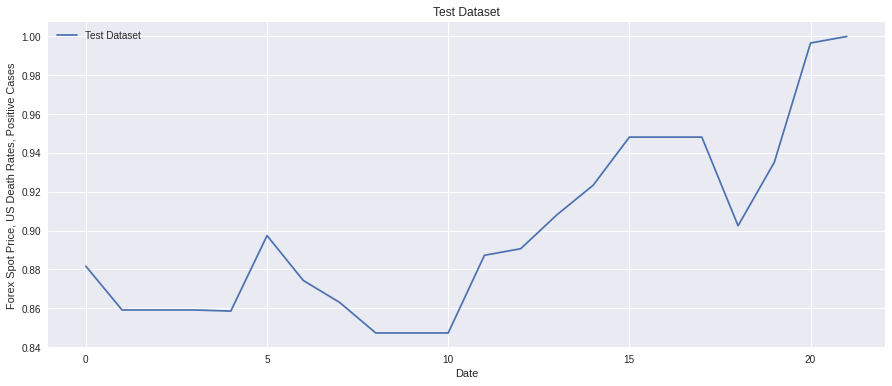

In [16]:
# End
plt.plot(test_data, label="Test Dataset")
plt.title('Test Dataset')
plt.ylabel('Forex Spot Price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

In [17]:
# Looking at first 4 days i.e. index 4 does not count
print(valset_data[:4])

[[0.82638106]
 [0.80496054]
 [0.80496054]
 [0.80496054]]


In [18]:
print(training_size, test_size)
print(len(train_data), len(test_data))
train_data.shape

171 21
171 22


(171, 1)

# X_train, Y_train, X_test, Y_test

In [19]:
# Convert an array of values into a dataset matrix
# time_step = how many previous days you have to consider before making a prediction. = 1 passing by ref
def create_dataset(dataset, time_step=1):
  dataX, dataY = [],[]
  # len(dataset) = 154 - 7 = 147 -1 (guarentees 8th datapoint)
  # for i(starting point of dataset), i in range 146
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step)]  # from i: until i + 7
    dataX.append(a) # then attach it to dataX
    y = dataset[i + time_step] # attach the feature index 2 which is forex of 3 data predictions to y
    dataY.append(y)
  return np.array(dataX), np.array(dataY)

In [20]:
# Weekly_timestep means taking in 7 days of features at a time 
weekly_timestep = 7
X_train, Y_train = create_dataset(train_data, weekly_timestep)
X_val, Y_val = create_dataset(valset_data, weekly_timestep)
X_test, Y_test = create_dataset(test_data, weekly_timestep)

# Reshape data to input into CNN

In [21]:
print(X_train.shape), print(Y_train.shape)
print(X_train.shape), print(Y_train.shape)

(163, 7, 1)
(163, 1)
(163, 7, 1)
(163, 1)


(None, None)

In [22]:
X_train = X_train.reshape(163,7,1,1)
X_val = X_val.reshape(13,7,1,1)
X_test = X_test.reshape(14,7,1,1)


print(X_train.shape), print(Y_train.shape)
print(X_val.shape), print(Y_val.shape)
print(X_test.shape), print(Y_test.shape)

(163, 7, 1, 1)
(163, 1)
(13, 7, 1, 1)
(13, 1)
(14, 7, 1, 1)
(14, 1)


(None, None)

# Ignore from here for a moment

In [23]:
print(X_test.shape), print(Y_test.shape)


(14, 7, 1, 1)
(14, 1)


(None, None)

In [24]:
# Look back leading up to the 12 days before the day we care about

# X variables/ features that we care about
# Y variable/ output/ what we want to predict
look_back=7
num_samples=len(dataset)-look_back

# Get indices of access for the data
indices=np.arange(num_samples).astype(np.int)[:,None]+np.arange(look_back+1).astype(np.int)

data = dataset["Price"].values[indices] # Create the 2D matrix of training samples
x = data[:,:-1] # Each row represents 7 days in the past
y = data[:,-1] # Each output value represents the 8th day


In [25]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
# print(x_train)


# CNN Model

In [26]:
# stide/steps = 1 day at a time
  # activation = none
  # kernal side how mnay days you want to look at
  # filter: number of nodes you can extract?
  # a filter is a collection of kernels
  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, Flatten, Dropout

def cnn_model(lr_rate, filters_layers, optimizer_one):

  opt = None
  if optimizer_one == 'adam':
   opt = keras.optimizers.Adam(learning_rate=lr_rate)
  elif optimizer_one == 'sgd':
   opt = keras.optimizers.SGD(learning_rate=lr_rate)
  else:
   opt = keras.optimizers.Adamax(learning_rate=lr_rate)

  cnn = Sequential([
    
  Conv2D(filters= filters_layers, input_shape=(7, 1, 1), kernel_size=(1,1), strides=1),
  Dropout(0.2),
  Conv2D(filters= filters_layers, kernel_size=(1,1), strides=1),
  Dropout(0.2),
  Dense(5), #
  Flatten(), # to make 1D
  Dense(1) # output feature map
  ])
  cnn.compile(loss = 'mean_squared_error', optimizer= opt)
  # print(cnn.summary())
  return cnn
  

  

## Hyperparameter Tuning


*   Optimizers:
[Overview of different Optimizers for neural networks](https://medium.com/datadriveninvestor/overview-of-different-optimizers-for-neural-networks-e0ed119440c3#:~:text=Adagrad%20eliminates%20the%20need%20to,is%20no%20longer%20able%20learning.)
*   [Conceptual Guide for HP Tuning](https://medium.com/@jackstalfort/hyperparameter-tuning-using-grid-search-and-random-search-f8750a464b35)
*   [Consider this for Grid Search & Random Search](https://scikit-learn.org/stable/auto_examples/model_selection/plot_randomized_search.html)
*   [And this](https://stackoverflow.com/questions/58137140/randomizedsearchcv-with-keras-lstm-regression)
![Grid Search & Random Search](https://miro.medium.com/max/1200/1*ZTlQm_WRcrNqL-nLnx6GJA.png)



In [27]:
# Function to create the best model for hyperparameters method
def bestModel(least_loss, learning_rate_list, optimizer_list, filter_list):
  for each_filter in filter_list:
    for each_optimizer in optimizer_list:
      for each_learning_rate in learning_rate_list:
        our_model = cnn_model(each_learning_rate, each_filter, each_optimizer)
        our_model.fit(X_train, Y_train, 
                validation_data= 
                (X_val, Y_val)
                , epochs=100,batch_size=10,verbose=1,
                callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)])
        loss = our_model.evaluate(X_test, Y_test)
        if loss < least_loss:
          least_loss = loss
          best_learning_rate = each_learning_rate
          best_optimizer = each_optimizer
          best_filter= each_filter
    return least_loss, best_learning_rate, best_optimizer, best_filter


#EPOCHS = 1000

#history = model.fit(
#  normed_train_data, train_labels,
#  epochs=EPOCHS, validation_split = 0.2, verbose=0,
 # callbacks=[tfdocs.modeling.EpochDots()])

## Grid Search

*   We must choose candidates for good hidden layers and optimizers. Then plot a comparison.
*   List of optimizers: 
*   optimizers = ['SGD', 'RMSprop','adam','adagrad', 'adadelta', 'adamax','nadam', 'ftrl']
*   Callbacks: Restores best weights that is going to give u best model 
*   Consider changing batch size: slower the batch_size better training, because small dataset




In [28]:
filter_list = [15,30,10]
optimizer_list = ['adam', 'adamax']
learning_rate_list = [3e-3,3e-4]
least_loss_grid_search = 1
best_grid_search_model = bestModel(least_loss_grid_search, learning_rate_list, optimizer_list, filter_list)
print(best_grid_search_model)


Epoch 1/100
17/17 [==============================] - 0s 13ms/step - loss: 0.1183 - val_loss: 0.0103
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0462 - val_loss: 0.0160
Epoch 3/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0352 - val_loss: 0.0175
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0278 - val_loss: 0.0050
Epoch 5/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0231 - val_loss: 0.0111
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0217 - val_loss: 0.0072
Epoch 7/100
1/1 [==============================] - 0s 1ms/step - loss: 0.0051
Epoch 1/100
17/17 [==============================] - 0s 9ms/step - loss: 0.1361 - val_loss: 0.0162
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0990 - val_loss: 0.0087
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0753 - val_loss: 0.0079
Epoch 4/100
17/17 [===========

## Random Search


*   Why do we get different values here then we do for grid search? Shouldnt they be the same?



In [29]:
# Shuffle hidden_layer list
from random import seed
from random import shuffle


In [30]:
# Shuffling filter layers

filter_list = [15,30,10]
# Seed random number generator
seed(len(filter_list))
# Prepare a sequence
filter_sequence = filter_list
print(filter_sequence) # Before Shuffle
# Randomly shuffle the sequence hidden layers
shuffle(filter_sequence) 
print(filter_sequence) # After Shuffle

# Shuffling optimizers

optimizer_list = ['adam', 'adamax']
# Seed random number generator
seed(len(filter_sequence))
# Prepare a sequence
op_sequence = optimizer_list
print(op_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(op_sequence)
print(op_sequence) # After Shuffle

# Shuffling learning rate

learning_rate_list = [3e-3,3e-4]
# Seed random number generator
seed(len(filter_sequence))
# Prepare a sequence
lr_sequence = learning_rate_list
print(lr_sequence) # Before Shuffle
# Randomly shuffle the sequence
shuffle(lr_sequence)
print(lr_sequence) # After Shuffle

# Assigning least_loss
least_loss_random_search = 1
best_random_grid_model = bestModel(least_loss_random_search, lr_sequence, op_sequence, filter_sequence)
print(best_random_grid_model)

# random search = (0.0006903847679495811, 0.003, 'adam', 30)

[15, 30, 10]
[30, 10, 15]
['adam', 'adamax']
['adamax', 'adam']
[0.003, 0.0003]
[0.0003, 0.003]
Epoch 1/100
17/17 [==============================] - 0s 11ms/step - loss: 0.3983 - val_loss: 0.6152
Epoch 2/100
17/17 [==============================] - 0s 3ms/step - loss: 0.1944 - val_loss: 0.2946
Epoch 3/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0877 - val_loss: 0.1516
Epoch 4/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0539 - val_loss: 0.0868
Epoch 5/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0587 - val_loss: 0.0538
Epoch 6/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0472 - val_loss: 0.0360
Epoch 7/100
17/17 [==============================] - 0s 3ms/step - loss: 0.0434 - val_loss: 0.0312
Epoch 8/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0379 - val_loss: 0.0291
Epoch 9/100
17/17 [==============================] - 0s 4ms/step - loss: 0.0372 - val_loss: 0.0289
Epoch 10/100

In [31]:
# We want the smallest loss
# Therefore if random_search least loss is greater than grid search, make grid search best model the best model.
# 0 = least loss, 1 = learning rate, 2 = optimizer, 3 = neurons
if best_grid_search_model[0] > best_random_grid_model[0]:
  best_learning_rate = best_random_grid_model[1]
  best_optimizer = best_random_grid_model[2]
  best_filter = best_random_grid_model[3]
else:
  best_learning_rate = best_grid_search_model[1]
  best_optimizer = best_grid_search_model[2]
  best_filter = best_grid_search_model[3]
print(best_learning_rate)
print(best_optimizer)
print(best_filter)

0.003
adam
30


# Best Model Prediction

In [32]:
best_param_model = cnn_model(best_learning_rate, best_filter, best_optimizer)
best_param_model.fit(X_train, Y_train, epochs=150,batch_size=10,verbose=1)
loss = best_param_model.evaluate(X_test, Y_test) 

Epoch 1/150
17/17 [==============================] - 0s 3ms/step - loss: 0.1261
Epoch 2/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0441
Epoch 3/150
17/17 [==============================] - 0s 2ms/step - loss: 0.0315
Epoch 4/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0285
Epoch 5/150
17/17 [==============================] - 0s 2ms/step - loss: 0.0229
Epoch 6/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0208
Epoch 7/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0179
Epoch 8/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 9/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 10/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0154
Epoch 11/150
17/17 [==============================] - 0s 2ms/step - loss: 0.0123
Epoch 12/150
17/17 [==============================] - 0s 3ms/step - loss: 0.0117
Epoch 13/150
17/17 [=================

# Using best model to predict on X_train & X_test

In [33]:
# Prediction and check performance metric
train_predict = best_param_model.predict(X_train)
test_predict = best_param_model.predict(X_test)
print(train_predict.shape)
print(test_predict.shape)

(163, 1)
(14, 1)


# Performance Metric

*   How well is model performing? A measure of what i am predicting and what should have been predicting.
*  **Mean Absolute Error**: MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. 
*   **Mean Squared Error**: Measures the average of the squares of the errors—that is, the average squared difference between the estimated values and the actual value.





In [34]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(Y_train, train_predict))
print(mean_absolute_error(Y_test, test_predict))

0.03434463809776807
0.05862063172359257


In [35]:
from sklearn.metrics import mean_squared_error
print(math.sqrt(mean_squared_error(Y_train, train_predict)))
print(math.sqrt(mean_squared_error(Y_test, test_predict)))

0.04775355071159194
0.06462731805934413


# Train Prediction, Validation & Test Prediction Versus Actual Data


*   Train Predicted
*   Validation Predicted on train data
*   Test Predicted
*   All on graph


In [36]:
# Transform back to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict =scaler.inverse_transform(test_predict)


## Train Predicted

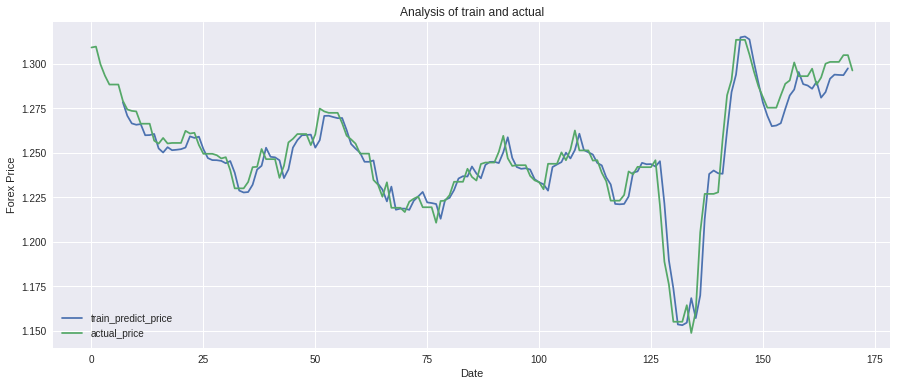

In [37]:
look_back = 7

trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back] = train_predict

trainPredictPlot = [item[0] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict_price")

train_panda = pd.DataFrame(train_data)
plt.plot(scaler.inverse_transform(train_panda), label="actual_price")

plt.title('Analysis of train and actual')
plt.ylabel('Forex Price')
plt.xlabel('Date')
plt.legend()
plt.show()

## Custom 21 day prediction (21 is the length of our validation dataset)

*   Training train data to predict future days and evaluating the accuracy on validation data.
*   Training train data to predict future days, no way of evaluating however this can tell us what is likely to occur.
*   Using last 7 days of training data to predict the future custom days(21). 



In [38]:
# Taking the last 7 days of test
X_input=test_data[100:].reshape(1,-1)
print(X_input)
X_input.shape
temp_input = train_data[-7:] # start, end 
temp_input

[]


array([[0.85231116],
       [0.85794814],
       [0.85794814],
       [0.85794814],
       [0.87936866],
       [0.87936866],
       [0.83089064]])

In [39]:
# Demonstrate prediction for the next 21 days:

# Step 1. 7 days of feature = temp_input taken from the last 7 days of the training set
# Step 2  i is the day you are on and we want to predict 4 days: 0,1,2,3 (4 days)
# Step 3. Predict the 8th day on each of the 7 days,
# Step 4. Add this new predicted day to the list
# Step 5. Because we are now taking in the last 7 days + the new predicted value, the list is now size 8  
# Step 6. In order to take in 7 days at a time, we shift 1 to the right.
# Step 7. We reassign the X_train to the new 7 days
# Step 8. We predict the 8th day of the 7 days and continue the process
# Step 9. We then add the 8th day to the output list
# Step 10. We keep track of the 4 days by incrementing by i at the end-> i = i+1
# Step 11. Once we have predicted the 4 days, we return the list of 4 day values.


from numpy import array
custom_day = len(valset_data)
lst_output=[]
n_steps=7
i=0
X_input = temp_input
while(i<custom_day):
  if(len(temp_input)>7):
    X_input=array(temp_input[1:])
    X_input=X_input.reshape((1,n_steps,1, 1))    # Prediction of X_input
    Y_hat = best_param_model.predict(X_input)
    # print(Y_hat)
    temp_input = np.append(temp_input, Y_hat)
    temp_input=temp_input[1:]
    lst_output.append(Y_hat[0][0])
    i=i+1
  else:
    X_input=X_input.reshape((1,n_steps,1, 1))
    Y_hat = best_param_model.predict(X_input, verbose=0)
    temp_input = np.append(temp_input, Y_hat)
    lst_output.append(Y_hat[0][0])
    i=i+1
print(lst_output)     # Print the predicted forex price for the next 4 days 

[0.7870151, 0.74014884, 0.69074184, 0.6405462, 0.5889828, 0.54076684, 0.49839932, 0.46171212, 0.43140596, 0.4077701, 0.39090627, 0.38069585, 0.37654102, 0.37771368, 0.38343388, 0.39283207, 0.40501377, 0.41908568, 0.43419892, 0.44958967, 0.46459067]


### Plotting evaluation: Training Prediction of 21 days Versus 21 days of Validation Data.

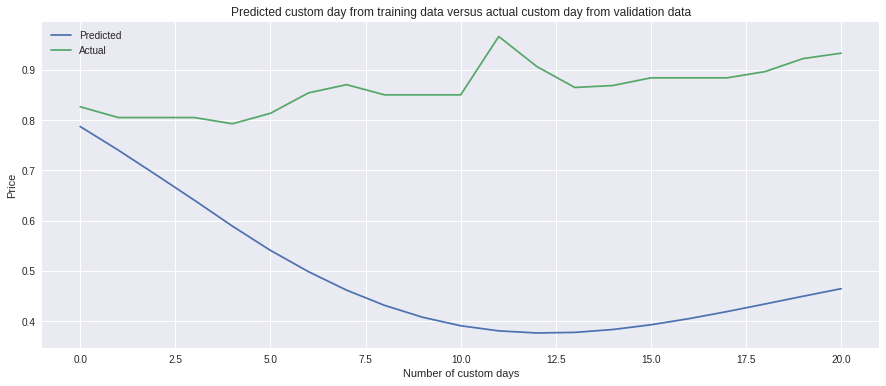

In [43]:
# Custom day plotted
day_new = custom_day-1

# Predicted 4 days from training
# Plot and label
# Transform back to original value before normalised
custom_day_prediction = np.array(lst_output)
# print(custom_day_prediction)
plt.plot(custom_day_prediction, label="Predicted")
# plt.plot(day_new, scaler.inverse_transform([custom_day_prediction]))

# Actual 4 days from validation
# Plot and label
# Transform back to original value before normalised
val_data = [item[0] for item in valset_data] 
custom_day_validation = val_data[:custom_day]
# print(custom_day_validation)
plt.plot(custom_day_validation, label="Actual")
# plt.plot(day_new, scaler.inverse_transform([custom_day_validation]))

# Information
plt.title('Predicted custom day from training data versus actual custom day from validation data')
plt.xlabel('Number of custom days')
plt.ylabel('Price')
plt.legend()
plt.show()



## Test Plot

14


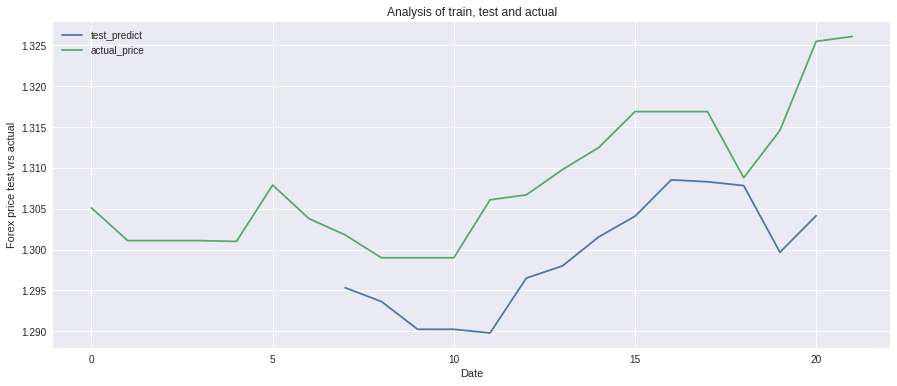

In [41]:
# Problem: testPredictPlot[len(train_predict)+(look_back*2)+2: (training_size + test_size)] = test_predict
# What does this do eactly other than populate the train predict

# Taking in the 7 
look_back = 7

testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
print(len(test_predict))

testPredictPlot[look_back:len(test_predict)+look_back] = test_predict
testPredictPlot = [item[0] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")

test_panda = pd.DataFrame(test_data)
plt.plot(scaler.inverse_transform(test_panda), label="actual_price")

plt.title('Analysis of train, test and actual')
plt.ylabel('Forex price test vrs actual')
plt.xlabel('Date')
plt.legend()
plt.show()



## Plotting Predicted Train, Test, Validation on Graph as well as Actual Dataset

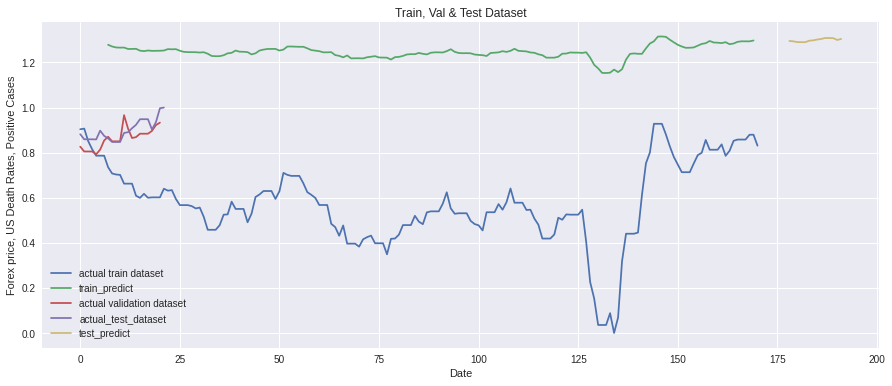

In [42]:
# All of the above + actual data
# Problem why is this not printing out right?
# How can I make my legends tidier?

# Start
plt.plot(train_data, label="actual train dataset")
# Predicted Train
trainPredictPlot = np.empty_like(new_dataset)
trainPredictPlot[:,:]= np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
trainPredictPlot = [item[0] for item in trainPredictPlot] 
plt.plot(trainPredictPlot, label="train_predict")

# Middle
plt.plot(valset_data, label="actual validation dataset")
# insert predicted val

# End
plt.plot(test_data, label="actual_test_dataset")
# Predicted
testPredictPlot = np.empty_like(new_dataset)
testPredictPlot[:,:]= np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1: (training_size + test_size)] = test_predict
testPredictPlot = [item[0] for item in testPredictPlot] 
plt.plot(testPredictPlot, label="test_predict")
# insert predict test

# as you can see th test data and train is divided because we want to test after a specific day
plt.title('Train, Val & Test Dataset')
plt.ylabel('Forex price, US Death Rates, Positive Cases')
plt.xlabel('Date')
plt.legend()
plt.show()

# Conclusion and next steps

After exploring the CNN algorithm:
*   Notes on working with CNN & Small Dataset
*   Notes on overfitting

In conclusion it seems that ..